In [1]:
!pip install scikit-learn-extra

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn import metrics

     |████████████████████████████████| 1.7 MB 12.0 MB/s 
     |████████████████████████████████| 22.3 MB 1.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# 1. Завантаження та огляд даних

Кожен запис є прикладом "руки" в покері, що складається з п’яти гральних карт, витягнутих зі стандартної колоди 52. Кожна карта описується двома атрибутами (масті та рангу), загалом 10. Існує один атрибут ***CLASS***, який описує силу (можливість виграшу) покерної "руки". Порядок карт важливий, тому існує 480 можливих роздач **Роял Флеш** порівняно з 4 (по одній для кожної масті).

<h2>Інформація про атрибути:</h2>

1) ***S1*** "Масть картки № 1" Порядковий (1-4), що представляє *{чирви, піки, бубни, трефи}*

2) ***C1*** "Ранг картки № 1" Числовий (1-13), що представляє (туз, 2, 3, ..., королева, король)

3) ***S2*** "Масть картки № 2" Порядковий (1-4), що представляє *{чирви, піки, бубни, трефи}*

4) ***C2*** "Ранг картки № 2" Числовий (1-13), що представляє (туз, 2, 3, ..., королева, король)

5) ***S3*** "Масть картки № 3" Порядок (1-4), що представляє *{чирви, піки, бубни, трефи}*

6) ***C3*** "Ранг картки № 3" Числовий (1-13), що представляє (туз, 2, 3, ..., королева, король)

7) ***S4*** "Масть картки № 4" Порядок (1-4), що представляє *{чирви, піки, бубни, трефи}*

8) ***C4*** "Ранг картки № 4" Числовий (1-13), що представляє (туз, 2, 3, ..., королева, король)

9) ***S5*** "Масть картки #5" Порядковий (1-4), що представляє *{чирви, піки, бубни, трефи}*

10) ***C5*** "Ранг картки 5" Числовий (1-13), що представляє (Туз, 2, 3, ..., Королева, Король)

11) ***CLASS*** Класифікація покерної "руки" Порядковий (0-9)

<h2>Можливі значення атрибуту CLASS</h2>

***0: Нічого в руках***; не визнана покерна рука

***1: Одна пара***; одна пара рівних рангів у межах п’яти карт

***2: Дві пари***; дві пари рівних рангів у межах п’яти карт

***3: Сет***; три рівні ранги в межах п’яти карт

***4: Стріт***; п'ять карт, послідовно ранжованих без пропусків

***5: Флеш***; п'ять карт однієї масті

***6: Фул гауз***; пара + сет

***7: Каре***; чотири рівні ранги в межах п’яти карт

***8: Стріт Флеш***; стріт + флеш

***9: Роял Флеш***; {Туз, Король, Королева, Валет, Десять} + флеш

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/MrPer4ik/PatternRecognition/main/poker.csv')
data.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,CLASS
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0


In [3]:
data.describe()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,CLASS
count,99998.000000,99998.000000,99998.000000,99998.000000,99998.000000,99998.00000,99998.000000,99998.000000,99998.000000,99998.000000,99998.000000
mean,2.500240,6.987280,2.499790,7.022550,2.506000,6.99866,2.499060,6.989370,2.501630,6.994990,0.617432
std,1.116375,3.750611,1.117941,3.749971,1.117012,3.74298,1.116652,3.746577,1.119111,3.741262,0.772401
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,4.000000,2.000000,4.000000,2.000000,4.00000,2.000000,4.000000,1.000000,4.000000,0.000000
50%,2.000000,7.000000,2.000000,7.000000,3.000000,7.00000,2.000000,7.000000,3.000000,7.000000,0.000000
75%,3.000000,10.000000,4.000000,10.000000,4.000000,10.00000,3.000000,10.000000,4.000000,10.000000,1.000000
max,4.000000,13.000000,4.000000,13.000000,4.000000,13.00000,4.000000,13.000000,4.000000,13.000000,7.000000


Випадковим чином обираємо 5000 прикладів для формування вибірки, які, в свою чергу, розділяємо на навчальну та тестову вибірки (70% до 30%). Також визначаємо кількість кластерів, що рівна 8. Вже можна зробити висновок, що такі комбінації як стріт та роял флеш не представлені у даній вибірці.

In [4]:
indexes = np.array([np.random.choice(np.where(data.CLASS <= 2)[0], 2500), 
                    np.random.choice(np.where(data.CLASS > 2)[0], 2500)])
indexes = np.reshape(indexes, (5000, ))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[indexes, :-1], 
                                                    data.iloc[indexes, -1], 
                                                    test_size=0.3, 
                                                    stratify=data.iloc[indexes, -1])
n_clusters = y_train.unique().shape[0]

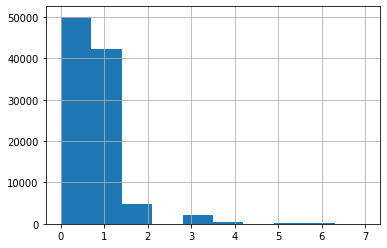

In [18]:
data.CLASS.hist()

# 2. Первинний аналіз та підготовка даних

Опишемо функції для відображення на екрані кореляційної матриці, а також візуалізації даних на площині.

In [6]:
def plot_corr_matrix(X, y, size=7):
    corr = X.assign(CLASS=y.values).corr()
    plt.figure(num=None, figsize=(size, size), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Кореляційна матриця', fontsize=15)
    plt.show()

In [7]:
def plot_2D(X, y, n_clusters=8):
    plt.figure(figsize=(10, 10))
    for class_value in range(n_clusters):
        row_ix = np.where(y == class_value)
        plt.scatter(X.iloc[row_ix[0], 0], X.iloc[row_ix[0], 1], 
                    label=class_value)
    if n_clusters <= 8:
        plt.legend()
    plt.show()

Дані ***до*** обробки можна побачити нижче.



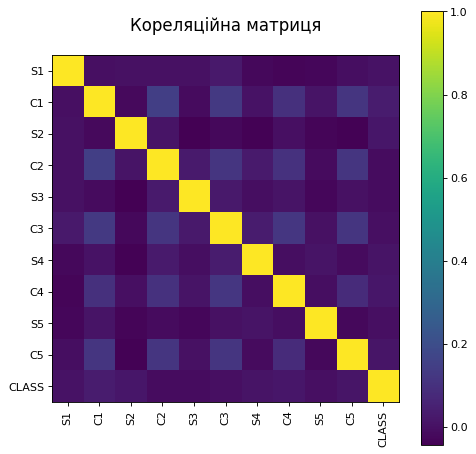

In [8]:
plot_corr_matrix(X_train, y_train)

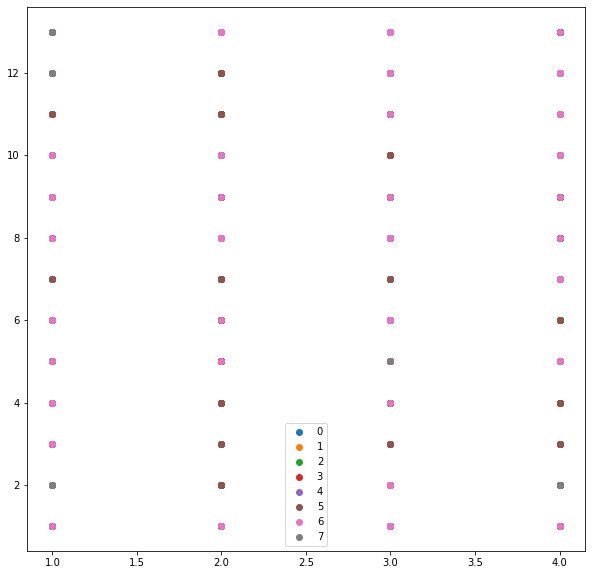

In [9]:
plot_2D(X_train, y_train)

Застосуємо мінімаксну нормалізацію для того, щоб дані не були дискретними, і до обох наборів даних: навчальних та тестових.

In [10]:
scaler = MinMaxScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_train_sc.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
0,0.000000,1.000000,0.333333,0.583333,0.333333,0.250000,1.000000,1.000000,0.666667,0.750000
1,0.333333,0.416667,0.666667,0.833333,0.333333,0.916667,1.000000,1.000000,0.333333,0.166667
2,0.000000,0.416667,0.333333,0.333333,0.333333,0.583333,0.333333,0.416667,0.000000,0.666667
3,0.333333,0.250000,1.000000,0.500000,0.000000,0.416667,1.000000,0.583333,1.000000,0.333333
4,0.666667,0.166667,0.333333,0.500000,1.000000,0.583333,0.333333,0.250000,0.666667,1.000000


Виконаємо зменшення розмірності за допомогою аналізу головних компонент. Будемо залишати лише ту кількість ознак, які можуть зберегти хоча б 90% дисперсії. Ця кількість виявилася рівною 8.

In [11]:
pca = PCA()
pca.fit(X_train_sc)
n_comp = sum(np.cumsum(pca.explained_variance_ratio_) < 0.9)
pca = PCA(n_components=n_comp)
X_train_sc = pd.DataFrame(pca.fit_transform(X_train_sc))
X_test_sc = pd.DataFrame(pca.transform(X_test_sc))
X_train_sc.head()

,0,1,2,3,4,5,6,7
0,-0.598802,0.471164,0.431196,0.164914,-0.133839,0.094210,0.053904,-0.098437
1,-0.277565,0.111148,0.554647,-0.163866,-0.252320,-0.129732,0.607892,-0.177519
2,0.061486,-0.011628,0.088607,0.236813,-0.412505,0.596126,-0.039991,0.204564
3,0.223866,0.814210,0.325087,-0.233766,-0.044106,-0.431307,0.144995,0.047690
4,-0.195552,-0.306956,-0.439261,0.114818,0.149688,-0.147038,-0.351800,0.472737


Дані ***після*** обробки можна побачити нижче.

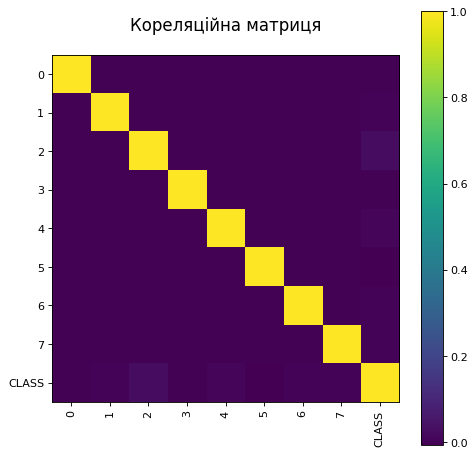

In [17]:
plot_corr_matrix(X_train_sc, y_train)

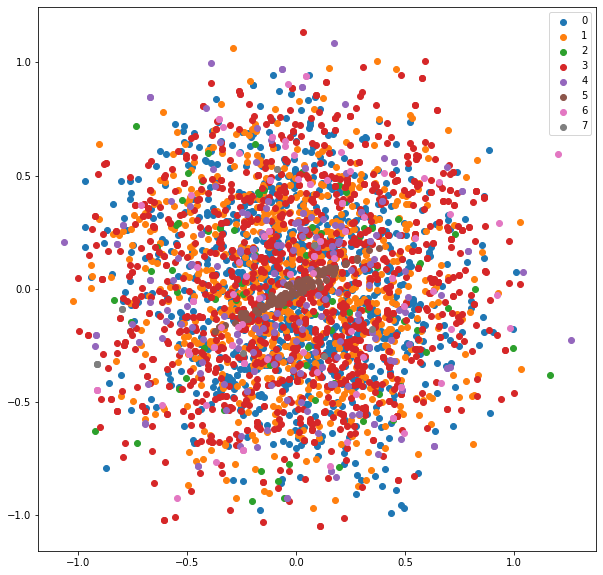

In [12]:
plot_2D(X_train_sc, y_train)

# 3. Використання методів кластеризації

2. Affinity Propagation 
3. k-medoids (місяць народження - березень)
5. Ієрархічна кластеризація (номер у списку 19)

Для пошуку найкращої моделі будемо використовувати решітчастий пошук для визначених параметрів, а також напишемо функцію, яка буде виводити на екран основні метрики, які описують якість отриманої кластеризації: ***Homogeneity, Completeness, V-measure, Adjusted Rand Index, Adjusted Mutual Information, Silhouette Coefficient***.

In [13]:
def print_results(y_true, y_pred, X, n_clusters=8):
    if n_clusters != 8:
        print(f'Estimated number of clusters: {n_clusters}')
    print(f"Homogeneity: %0.3f" % metrics.homogeneity_score(y_true, y_pred))
    print("Completeness: %0.3f" % metrics.completeness_score(y_true, y_pred))
    print("V-measure: %0.3f" % metrics.v_measure_score(y_true, y_pred))
    print("Adjusted Rand Index: %0.3f"
        % metrics.adjusted_rand_score(y_true, y_pred))
    print("Adjusted Mutual Information: %0.3f"
        % metrics.adjusted_mutual_info_score(y_true, y_pred))
    print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X, y_pred, metric='sqeuclidean'))
    plot_2D(X, y_pred, n_clusters)

Best model with damping = 0.5
***** TRAIN SCORE *****
Estimated number of clusters: 197
Homogeneity: 0.213
Completeness: 0.063
V-measure: 0.097
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.045
Silhouette Coefficient: 0.199


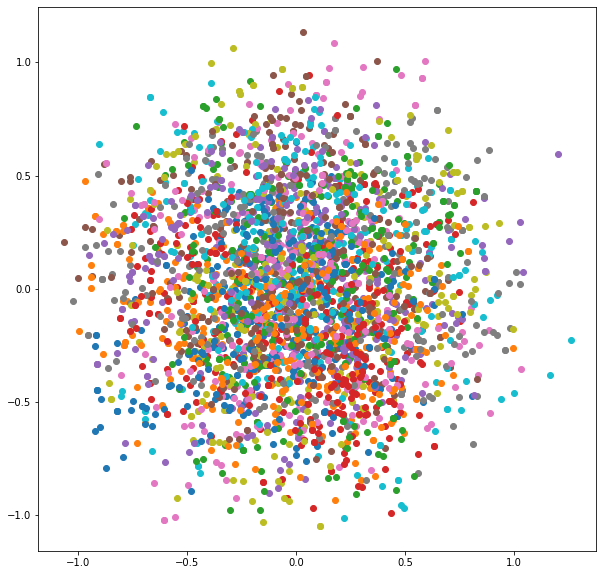

***** TEST SCORE *****
Estimated number of clusters: 197
Homogeneity: 0.312
Completeness: 0.094
V-measure: 0.144
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.038
Silhouette Coefficient: 0.060


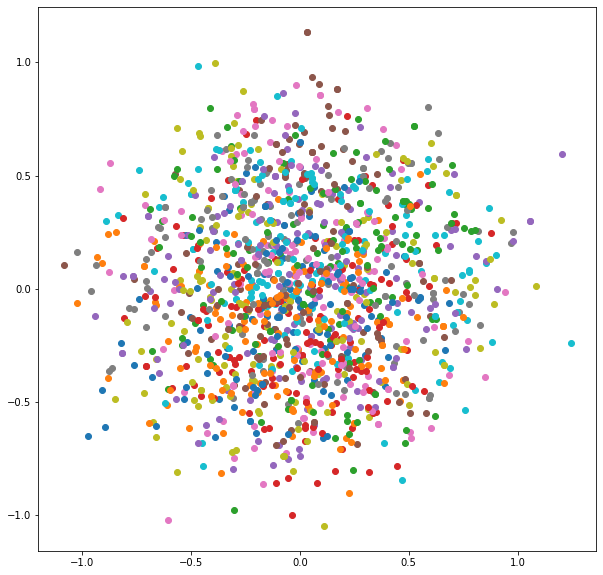

In [14]:
parameters = {'damping': [0.5, 0.7, 0.9]}

af = AffinityPropagation(random_state=42)
grid = GridSearchCV(af, parameters, cv=5, n_jobs=-1, refit='adjusted_mutual_info_score', 
                    scoring=['adjusted_mutual_info_score', 'adjusted_rand_score', 'homogeneity_score'])
grid.fit(X_train_sc, y_train)
af = grid.best_estimator_
cluster_centers_indices = af.cluster_centers_indices_
y_pred = af.predict(X_test_sc)
labels = af.labels_
print(f'Best model with damping = {af.damping}')

n_clusters_ = len(cluster_centers_indices)
print('***** TRAIN SCORE *****')
print_results(y_train, labels, X_train_sc, n_clusters_)

print('***** TEST SCORE *****')
print_results(y_test, y_pred, X_test_sc, n_clusters_)

/usr/local/lib/python3.7/dist-packages/sklearn_extra/cluster/_k_medoids.py:247: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Best model with method = pam and init = heuristic
***** TRAIN SCORE *****
Homogeneity: 0.031
Completeness: 0.023
V-measure: 0.026
Adjusted Rand Index: 0.004
Adjusted Mutual Information: 0.023
Silhouette Coefficient: 0.149


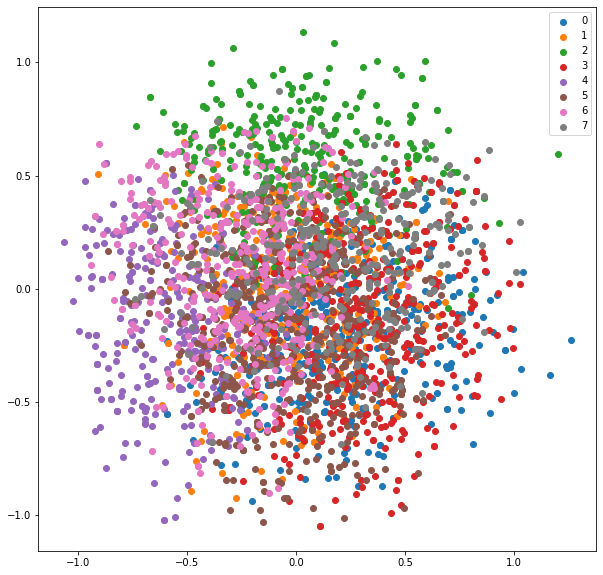

***** TEST SCORE *****
Homogeneity: 0.037
Completeness: 0.028
V-measure: 0.032
Adjusted Rand Index: 0.003
Adjusted Mutual Information: 0.023
Silhouette Coefficient: 0.148


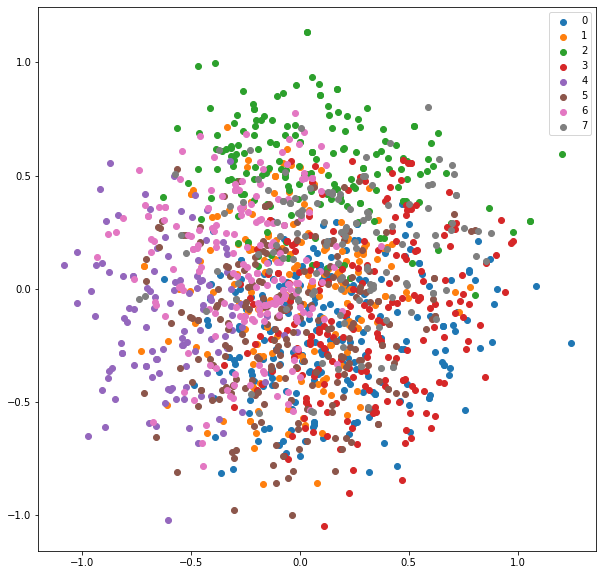

In [15]:
parameters = {'method': ['alternate', 'pam'],
              'init': ['random', 'heuristic', 'k-medoids++', 'build']}

km = KMedoids(n_clusters=8, random_state=42)
grid = GridSearchCV(km, parameters, cv=5, n_jobs=-1, refit='adjusted_mutual_info_score', 
                    scoring=['adjusted_mutual_info_score', 'adjusted_rand_score', 'homogeneity_score'])
grid.fit(X_train_sc, y_train)
km = grid.best_estimator_
y_pred = km.predict(X_test_sc)
labels = km.labels_
print(f'Best model with method = {km.method} and init = {km.init}')

print('***** TRAIN SCORE *****')
print_results(y_train, labels, X_train_sc)

print('***** TEST SCORE *****')
print_results(y_test, y_pred, X_test_sc)

***** TRAIN SCORE *****
Homogeneity: 0.026
Completeness: 0.020
V-measure: 0.022
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.018
Silhouette Coefficient: 0.065


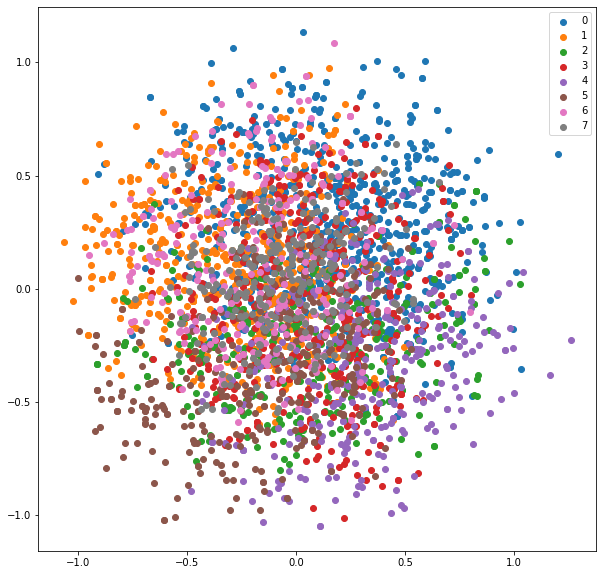

***** TEST SCORE *****
Homogeneity: 0.023
Completeness: 0.018
V-measure: 0.020
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.011
Silhouette Coefficient: 0.077


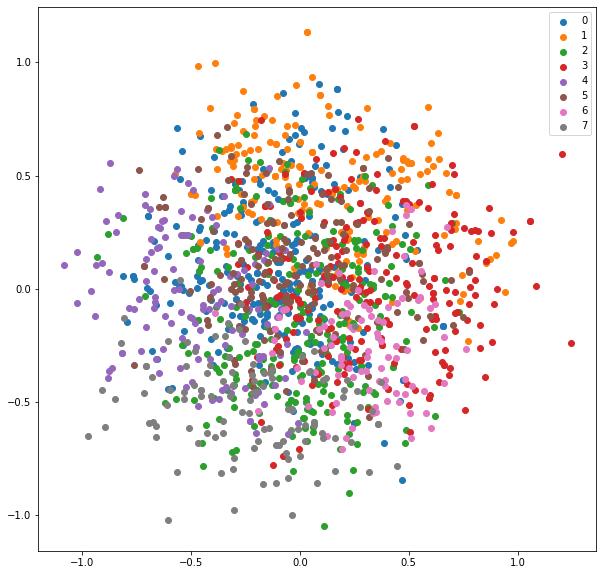

In [16]:
ac = AgglomerativeClustering(n_clusters=8)
ac.fit_predict(X_train_sc)
labels = ac.labels_
ac.fit_predict(X_test_sc)
y_pred = ac.labels_

print('***** TRAIN SCORE *****')
print_results(y_train, labels, X_train_sc)

print('***** TEST SCORE *****')
print_results(y_test, y_pred, X_test_sc)

# Порівняння отриманих моделей за допомогою метрик якості

Слід зазначити, що за основними ознаками, за якими відбувався відбір найкращої моделі, найякіснішою виявилася кластеризація, побудована за допомогою **AffinityPropagation**. Вона має найбільше значення метрики гомогенності та V-метрики. ОДНАК, якщо звернути увагу на кількість отриманих кластерів, то стане зрозуміло, що вищі значення метрик пов'язані з тим, що переважна більшість прикладів було віднесено до неіснуючих кластерів, яких у моделі наявно 197 (включно з 8 вихідними). Отже, ця модель не є придатною для використання.

Отже, найкращою моделлю серед розглянутих визначимо саме **KMedoids**, так як усі її метрики якості переважають над відповідними для ієрархічної кластеризації. Так, ці значення доволі низькі через те, що набір даних виявився доволі складним для кластеризації. На мою думку, для успішного прогнозування в даних умовах найкраще підійде алгоритм дерева рішень або випадкового лісу. Тоді навіть буде непотрібною нормалізація даних.